# Model training and predictions



## 1: Importing libraries


In [ ]:
folder_path  = "/content/drive/MyDrive/MTX Basketball classfication"

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import keras
from keras.models import Sequential
from keras.applications.vgg16 import VGG16
from keras.layers import Dense, InputLayer, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D
from keras.preprocessing import image
from keras.utils import np_utils
import numpy as np
import pandas as pd
from tqdm import tqdm
from keras.applications.vgg16 import VGG16
import cv2
import math
import os
from glob import glob
from scipy import stats as s
import matplotlib.pyplot as plt    
%matplotlib inline

from skimage.transform import resize  
from sklearn.model_selection import train_test_split
from tqdm import tqdm

## 2: Preprocessing

### Storing the names of the videos and corresponding classes in a dataframe: 
1 for scoring and 0 for non-scoring

#### Train videos

In [ ]:
DIR1 = folder_path+"/Training_Data/scoring_clips"
DIR2 = folder_path+"/Training_Data/non_scoring_clips"

vnames_scoring = [entry for entry in os.listdir(DIR1)]  # Names of scoring videos
vnames_non_scoring = [entry for entry in os.listdir(DIR2)] # Names of non_scoring videos
print(len(vnames_scoring))
print(len(vnames_non_scoring))
vnames = vnames_scoring+vnames_non_scoring
vclasses = list(np.ones(len(vnames_scoring),dtype = np.int8)) + list(np.zeros(len(vnames_non_scoring),dtype = np.int8)) 
print(len(vnames))
print(len(vclasses))

885
1309
2194
2194


In [ ]:
# creating a dataframe having video names
train = pd.DataFrame()
train['video_name'] = vnames
train['tag'] = vclasses
train.head()

,video_name,tag
0,clip_68.mp4,1
1,clip_685.mp4,1
2,clip_566.mp4,1
3,clip_872.mp4,1
4,clip_158.mp4,1


#### Test videos

In [ ]:
testDIR1 = folder_path+"/Public_Test_Data/scoring_clips"
testDIR2 = folder_path+"/Public_Test_Data/non_scoring_clips"

testvnames_scoring = [entry for entry in os.listdir(testDIR1)]  # Names of scoring videos
testvnames_non_scoring = [entry for entry in os.listdir(testDIR2)] # Names of non_scoring videos
print(len(testvnames_scoring))
print(len(testvnames_non_scoring))
testvnames = testvnames_scoring+testvnames_non_scoring
testvclasses = list(np.ones(len(testvnames_scoring),dtype = np.int8)) + list(np.zeros(len(testvnames_non_scoring),dtype = np.int8)) 
print(len(testvnames))
print(len(testvclasses))

208
291
499
499


In [ ]:
# creating a dataframe having video names
test = pd.DataFrame()
test['video_name'] = testvnames
test['tag'] = testvclasses
test.head()

,video_name,tag
0,clip_493.mp4,1
1,clip_455.mp4,1
2,clip_785.mp4,1
3,clip_791.mp4,1
4,clip_834.mp4,1


### Extracting the frames of train videos (2 frames per video) and saving them

In [ ]:
# =================== TRAIN: SCORING =======================================================
# storing the frames from training videos
inames_scoring=[]
for i in tqdm(range(len(vnames_scoring))):
    count = 0
    videoFile = train['video_name'][i]
    cap = cv2.VideoCapture(folder_path+'/Training_Data/scoring_clips/'+videoFile)   # capturing the video from the given path
    frameRate = cap.get(5)
    x=1
    while(cap.isOpened()):
        frameId = cap.get(1)
        ret, frame = cap.read()
        if (ret != True):
            break
        if (frameId % math.floor(frameRate) == 0):
            # storing the frames in a new folder named train
            filename = folder_path+'/train/' + videoFile +"_frame%d.jpg" % count;count+=1
            inames_scoring.append(filename)
            cv2.imwrite(filename, frame)
    cap.release()

100%|██████████| 885/885 [11:34<00:00,  1.28it/s]


In [ ]:
# =================== TRAIN: NON-SCORING =======================================================
# storing the frames from training videos
inames_non_scoring=[]
for i in tqdm(range(len(vnames_scoring),len(vnames))):
    count = 0
    videoFile = train['video_name'][i]
    cap = cv2.VideoCapture(folder_path+'/Training_Data/non_scoring_clips/'+videoFile)   # capturing the video from the given path
    frameRate = cap.get(5)
    x=1
    while(cap.isOpened()):
        frameId = cap.get(1)
        ret, frame = cap.read()
        if (ret != True):
            break
        if (frameId % math.floor(frameRate) == 0):
            # storing the frames in a new folder named train
            filename = folder_path+'/train/' + videoFile +"_frame%d.jpg" % count;count+=1
            inames_non_scoring.append(filename)
            cv2.imwrite(filename, frame)
    cap.release()

100%|██████████| 1309/1309 [21:23<00:00,  1.02it/s]


### Storing the paths of images and the corresponding classes in a dataframe

In [ ]:
print(len(inames_scoring))
print(len(inames_non_scoring))
inames = inames_scoring+inames_non_scoring
iclasses = list(np.ones(len(inames_scoring),dtype = np.int8)) + list(np.zeros(len(inames_non_scoring),dtype = np.int8)) 
print(len(inames))
print(len(iclasses))

10620
15708
26328
26328


In [ ]:
# creating a dataframe having video names
train_data = pd.DataFrame()
train_data['image'] = inames
train_data['class'] = iclasses

# converting the dataframe into csv file 
train_data.to_csv(folder_path+'/train_new.csv',header=True, index=False)

train_data.head()

,image,class
0,/content/drive/MyDrive/MTX Basketball classfic...,1
1,/content/drive/MyDrive/MTX Basketball classfic...,1
2,/content/drive/MyDrive/MTX Basketball classfic...,1
3,/content/drive/MyDrive/MTX Basketball classfic...,1
4,/content/drive/MyDrive/MTX Basketball classfic...,1


## 3: Training the model

### Reading all the frames and converting them to numpy arrays

In [ ]:
train = pd.read_csv(folder_path+'/train_new.csv')
train.head()

,image,class
0,/content/drive/MyDrive/MTX Basketball classfic...,1
1,/content/drive/MyDrive/MTX Basketball classfic...,1
2,/content/drive/MyDrive/MTX Basketball classfic...,1
3,/content/drive/MyDrive/MTX Basketball classfic...,1
4,/content/drive/MyDrive/MTX Basketball classfic...,1


In [ ]:
# creating an empty list
train_image = []

# for loop to read and store frames
for i in tqdm(range(train.shape[0])):
    # loading the image and keeping the target size as (224,224,3)
    img = image.load_img(train['image'][i], target_size=(224,224,3))
    # converting it to array
    img = image.img_to_array(img)
    # normalizing the pixel value
    img = img/255
    # appending the image to the train_image list
    train_image.append(img)
    
# converting the list to numpy array
X = np.array(train_image)

# shape of the array
X.shape

100%|██████████| 4388/4388 [30:20<00:00,  2.41it/s]


(4388, 224, 224, 3)

### Train-validation split


In [ ]:
# separating the target
y = train['class']

# creating the training and validation set
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2, stratify = y)

### Defining the model architecture and Training



1: We first use the predictions of the train data on standard VGG16 pretrained model (excluding the last layer)

2: The output of above is used as input our custom model with the below architecture:
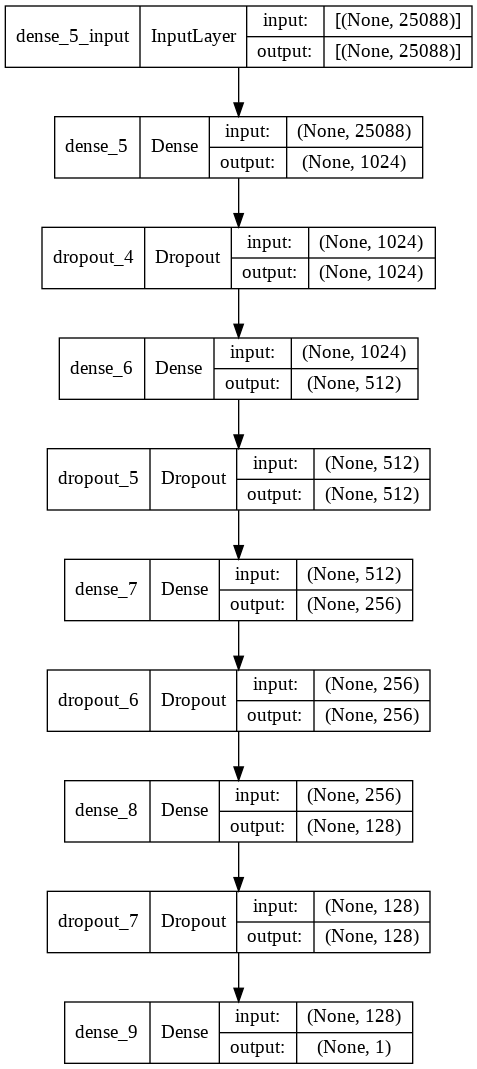

In [ ]:
# creating the base model of pre-trained VGG16 model
base_model = VGG16(weights='imagenet', include_top=False)

58900480/58889256 [==============================] - 1s 0us/step


In [ ]:
# extracting features for training frames

# TAKES AROUND 30 mins!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

X_train = base_model.predict(X_train)
X_train.shape

(3510, 7, 7, 512)

In [ ]:
# extracting features for validation frames
X_test = base_model.predict(X_test)
X_test.shape

(878, 7, 7, 512)

In [ ]:
# reshaping the training as well as validation frames in single dimension
X_train = X_train.reshape(3510, 7*7*512)
X_test = X_test.reshape(878, 7*7*512)

In [ ]:
# normalizing the pixel values
max = X_train.max()
X_train = X_train/max
X_test = X_test/max

In [ ]:
# shape of images
X_train.shape

(3510, 25088)

In [ ]:
#defining the model architecture
model = Sequential()
model.add(Dense(1024, activation='relu', input_shape=(25088,)))
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

In [ ]:
# defining a function to save the weights of best model
from keras.callbacks import ModelCheckpoint
mcp_save = ModelCheckpoint('weight.hdf5', save_best_only=True, monitor='val_loss', mode='min')

In [ ]:
# compiling the model
model.compile(loss='binary_crossentropy',optimizer='Adam',metrics=['accuracy'])

In [ ]:
# training the model
history=model.fit(X_train, y_train, epochs=200, validation_data=(X_test, y_test), callbacks=[mcp_save], batch_size=128)

Epoch 1/200
28/28 [==============================] - 12s 390ms/step - loss: 0.7314 - accuracy: 0.5467 - val_loss: 0.6698 - val_accuracy: 0.5968
Epoch 2/200
28/28 [==============================] - 11s 381ms/step - loss: 0.6758 - accuracy: 0.5860 - val_loss: 0.6480 - val_accuracy: 0.6754
Epoch 3/200
28/28 [==============================] - 11s 379ms/step - loss: 0.6308 - accuracy: 0.6330 - val_loss: 0.6066 - val_accuracy: 0.6879
Epoch 4/200
28/28 [==============================] - 11s 382ms/step - loss: 0.6088 - accuracy: 0.6655 - val_loss: 0.5891 - val_accuracy: 0.6720
Epoch 5/200
28/28 [==============================] - 11s 386ms/step - loss: 0.5863 - accuracy: 0.6977 - val_loss: 0.5733 - val_accuracy: 0.7005
Epoch 6/200
28/28 [==============================] - 11s 384ms/step - loss: 0.5589 - accuracy: 0.7168 - val_loss: 0.5720 - val_accuracy: 0.6913
Epoch 7/200
28/28 [==============================] - 10s 350ms/step - loss: 0.5289 - accuracy: 0.7279 - val_loss: 0.5748 - val_accuracy:

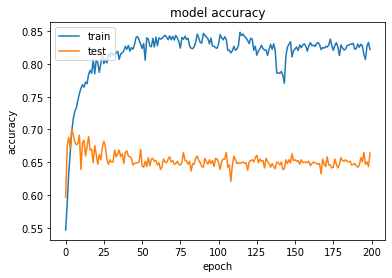

In [ ]:
# Plotting the train and validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

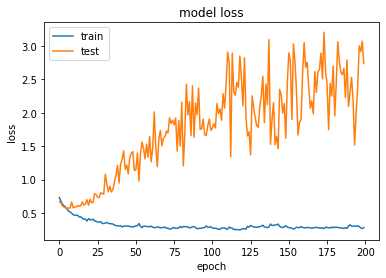

In [ ]:
# Plotting the train and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## 4: Evaluation using the given public test data

### Loading the model (Same architecture which is used for training

In [ ]:
base_model = VGG16(weights='imagenet', include_top=False)

In [ ]:
#defining the model architecture
model = Sequential()
model.add(Dense(1024, activation='relu', input_shape=(25088,)))
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

In [ ]:
# loading the trained weights
model.load_weights("/content/weight.hdf5")

In [ ]:
# compiling the model
model.compile(loss='binary_crossentropy',optimizer='Adam',metrics=['accuracy'])

### Predicting results for each test video

In [ ]:
test

,video_name,tag
0,clip_493.mp4,1
1,clip_455.mp4,1
2,clip_785.mp4,1
3,clip_791.mp4,1
4,clip_834.mp4,1
...,...,...
494,clip_1422.mp4,0
495,clip_3175.mp4,0
496,clip_1480.mp4,0
497,clip_165.mp4,0


In [ ]:
actual = test["tag"].values
predict = []
 
# ======================================= SCORING ===========================================================================================

# for loop to extract frames from each test video
for i in tqdm(range(len(testvnames_scoring))):
    count = 0
    videoFile = test["video_name"][i]
    cap = cv2.VideoCapture(folder_path+'/Public_Test_Data/scoring_clips/'+videoFile)   # capturing the video from the given path
    frameRate = cap.get(5) #frame rate
    x=1
    # removing all other files from the temp folder
    files = glob('temp/*')
    for f in files:
        os.remove(f)
    while(cap.isOpened()):
        frameId = cap.get(1) #current frame number
        ret, frame = cap.read()
        if (ret != True):
            break
        if (frameId % math.floor(frameRate) == 0):
            # storing the frames of this particular video in temp folder
            filename ='temp/' + "_frame%d.jpg" % count;count+=1
            cv2.imwrite(filename, frame)
    cap.release()
    
    # reading all the frames from temp folder
    images = glob("temp/*.jpg")
    
    prediction_images = []
    for i in range(len(images)):
        img = image.load_img(images[i], target_size=(224,224,3))
        img = image.img_to_array(img)
        img = img/255
        prediction_images.append(img)
        
    # converting all the frames for a test video into numpy array
    prediction_images = np.array(prediction_images)
    # extracting features using pre-trained model
    prediction_images = base_model.predict(prediction_images)
    # converting features in one dimensional array
    prediction_images = prediction_images.reshape(prediction_images.shape[0], 7*7*512)
    # predicting tags for each array
    prediction = model.predict(prediction_images)
    pred  = prediction.mean()
    if pred>0.5:
      ans = 1
    else:
      ans = 0
    # appending the mode of predictions in predict list to assign the tag to the video
    predict.append(ans)
 

# ============================================ NON-SCORING =====================================================================================

# for loop to extract frames from each test video
for i in tqdm(range(len(testvnames_scoring),test.shape[0])):
    count = 0
    videoFile = test["video_name"][i]
    cap = cv2.VideoCapture(folder_path+'/Public_Test_Data/non_scoring_clips/'+videoFile)   # capturing the video from the given path
    frameRate = cap.get(5) #frame rate
    x=1
    # removing all other files from the temp folder
    files = glob('temp/*')
    for f in files:
        os.remove(f)
    while(cap.isOpened()):
        frameId = cap.get(1) #current frame number
        ret, frame = cap.read()
        if (ret != True):
            break
        if (frameId % math.floor(frameRate) == 0):
            # storing the frames of this particular video in temp folder
            filename ='temp/' + "_frame%d.jpg" % count;count+=1
            cv2.imwrite(filename, frame)
    cap.release()
    
    # reading all the frames from temp folder
    images = glob("temp/*.jpg")
    
    prediction_images = []
    for i in range(len(images)):
        img = image.load_img(images[i], target_size=(224,224,3))
        img = image.img_to_array(img)
        img = img/255
        prediction_images.append(img)
        
    # converting all the frames for a test video into numpy array
    prediction_images = np.array(prediction_images)
    # extracting features using pre-trained model
    prediction_images = base_model.predict(prediction_images)
    # converting features in one dimensional array
    prediction_images = prediction_images.reshape(prediction_images.shape[0], 7*7*512)
    # predicting tags for each array
    prediction = model.predict(prediction_images)
    pred  = prediction.mean()
    if pred>0.5:
      ans = 1
    else:
      ans = 0
    # appending the mode of predictions in predict list to assign the tag to the video
    predict.append(ans)

100%|██████████| 291/291 [10:44<00:00,  2.22s/it]


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(test["tag"],predict))

              precision    recall  f1-score   support

           0       0.79      0.89      0.84       291
           1       0.81      0.66      0.73       208

    accuracy                           0.80       499
   macro avg       0.80      0.78      0.78       499
weighted avg       0.80      0.80      0.79       499



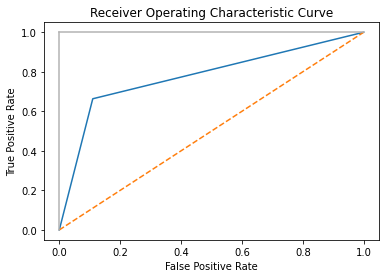

In [ ]:
from sklearn.metrics import roc_curve, auc
y_test=test["tag"].tolist()
false_positive_rate1, true_positive_rate1, threshold1 = roc_curve(y_test, predict,pos_label=1)

plt.title('Receiver Operating Characteristic Curve')
plt.plot(false_positive_rate1, true_positive_rate1)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


In [ ]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test,predict)

0.7767479513613533

In [ ]:
# checking the accuracy of the predicted scores
from sklearn.metrics import accuracy_score
accuracy_score(actual, predict)*100

77.55511022044088

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, balanced_accuracy_score
from sklearn.metrics import confusion_matrix

In [ ]:
f1_score(actual,predict)

0.7128205128205127

In [ ]:
confusion_matrix(actual,predict)

array([[248,  43],
       [ 69, 139]])

In [ ]:
test["Predicted"]=predict

In [ ]:
test.rename(columns={'tag':'Actual'},inplace=True)

In [ ]:
test.to_csv("Test_data_submission.csv",index=False)